# 4.2. Уравнение фильтрации и его решения - построение с использованием python и sympy

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

версия 0.2 от 22.10.2023

Хабибуллин Ринат 2021-2023 г.

---


# Содержание

* [1 Уравнение фильтрации](#421) 
* [2 Общее решение модифицированного уравнения Бесселя](#422) 
* [3 Частное решение для бесконечного пласта и конечного радиуса скважины](#423) 
* [4 Построение численных решений на основе аналитического  с использованием `mpmath`](#424) 
* [5 Построение численных решений на основе аналитического  с использованием `numpy` и `scipy`](#425) 
* [6 Частное решение для конечного круглого пласта с постоянным давлением на контуре и конечного радиуса скважины.](#426) 
    * [6.1. Построение решения с использованием `sympy.dsolve`](#4261) 
* [7 Частное решение для конечного круглого пласта с замкнутой границей и конечного радиуса скважины.](#427) 


Системы компьютерной алгебры могут заметно облегчить работу со сложными математическими выражениями, в частности в решениями уравнения фильтрации. В данной тетрадки соберем примеры работы с системой [sympy с использованием python](https://www.sympy.org/en/index.html). Эта система аналогична коммерческим системам [Wolfram Mathematica](https://www.wolfram.com/mathematica/) или [Maple](https://www.maplesoft.com/products/Maple/), и хотя не обладает столь же широкими возможностями, зато открыта и бесплатна и во многом способна помочь решать инженерные задачи. 

Для установки системы надо выполнить команду `pip install sympy`

In [1]:
# чтобы работало на колабе надо установить пакет для численного обратного преобразования Лапласа
!pip install anaflow

In [1]:
import sympy as sp

# для построения численных решений можно использовать два варианта - mpmath и numpy в связке с scipy 
import numpy as np
import mpmath as mp
# для построения графиков когда надо, используем matplotlib
import matplotlib.pyplot as plt
# для численного обратного преобразования Лапласа с использованием numpy и scipy функций
import anaflow

## 1 Уравнение фильтрации <a class="anchor" id="421"></a>

Рассматривается уравнение фильтрации в безразмерных переменных 

$$ 
\frac{\partial p_D}{ \partial t_D} = \frac{1}{r_D}\left[ \frac{ \partial{}}{ \partial{r_D} }\left( r_D \dfrac{\partial p_D}{ \partial r_D} \right) \right]  
\tag{1.1}
$$

где введены следующие безразмерные переменные
* $r_D$ - безразмерное расстояние от центра скважины
* $t_D$ - безразмерное время
* $p_D$ - безразмерное давление

Соответствующие определения безразмерных переменных

$$ r_D = \frac{r}{r_w} \tag{1.2}$$
$$ t_D = \frac{0.00036 kt}{\phi \mu c_t r_w^2}  \tag{1.3}$$
$$ p_D = \frac{kh}{ 18.41 q_s B \mu} \left( p_i - p \right)  \tag{1.4} $$

где в свою очередь 
* $q_s$ - дебит скважины на поверхности, приведенный к нормальным условиям, м3/сут
* $\phi$ - пористость, доли единиц
* $\mu$ - вязкость нефти в пласте, сП
* $B$ - объемный коэффициент нефти, м3/м3
* $p_i$ - начальное давление в пласте, атм
* $p$ - давление забойное, атм
* $c_t$ - общая сжимаемость системы в пласте, 1/атм
* $k$ - проницаемость, мД
* $t$ -  время, час
* $r$ - расстояние от центра скважины, м
* $r_w$ - радиус скважины, м

Решение такого уравнение может быть получено с использованием <a href="https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B0%D0%BF%D0%BB%D0%B0%D1%81%D0%B0"
                        target="_blank" rel="noreferrer noopener">преобразования Лапласа</a>.

$$ 
L \left [ f(t) \right] = \tilde{f}(u) = \int_{0}^{\infty}f(t)e^{-ut}dt 
\tag{1.4}
$$

где $u$ параметр пространства Лапласа соответствующий времени.

Тогда уравнение в пространстве Лапласа преобразуется к виду:

$$ 
u \widetilde{p_D}  =  \dfrac{1}{r_D} \left[\dfrac{d}{d r_D} \left(r_D \dfrac{d{\widetilde{p_D}}}{d r_D} \right) \right] 
\tag{1.5}
$$

Уравнение известно как  <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B8%D1%84%D0%B8%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F"> модифицированное уравнение Бесселя </a>. 
где 
* $u$ - переменная пространства Лапласа, соответствующая времени
* $\widetilde{p_D}(u, r_D)$ - изображение давления в пространстве Лапласа

С подобными уравнениями можно начать работать с использованием системы компьютерной алгебры [`sympy`](https://www.sympy.org/en/index.html). 

In [2]:
# определим переменные с которыми будем работать 

r_d = sp.symbols('r_D', real=True, positive=True)
p_d = sp.symbols('p_D', cls=sp.Function, real=True, positive=True)
u = sp.symbols('u',real=True, positive=True)
C1, C2 = sp.symbols('C1 C2')

In [3]:
# определим уравнение фильтрации в пространстве Лапласа
diff_eq = sp.Eq(u * p_d(r_d),
                1 / r_d * (sp.diff(r_d * sp.diff(p_d(r_d), r_d) , r_d)) )
diff_eq

Eq(u*p_D(r_D), (r_D*Derivative(p_D(r_D), (r_D, 2)) + Derivative(p_D(r_D), r_D))/r_D)

## 2 Общее решение модифицированного уравнения Бесселя <a class="anchor" id="422"></a>

In [4]:
# попробуем решить уравнение 
soln = sp.dsolve(diff_eq, p_d(r_d))
soln

Eq(p_D(r_D), C1*besseli(0, r_D*sqrt(u)) + C2*bessely(0, I*r_D*sqrt(u)))

In [5]:
# проверим, что решение полученное dsolve удовлетворяет уравнению
sp.checkodesol(diff_eq, soln)

(True, 0)

Уравнение Бесселя легко решается, 
$$\displaystyle \operatorname{p_{d}}{\left(r_{d} \right)} = C_{1} I_{0}\left(r_{d} \sqrt{u}\right) + C_{2} Y_{0}\left(i r_{d} \sqrt{u}\right) \tag{2.1}$$

хотя решение \eqref{2.1} по виду и немного отличается от того, что обычно приводится в книгах. Вместо мофицированной функции Бесселя второго рода $K_0(x)$ решение выражается через функцию Бесселя второго рода $Y_0(ix)$ для мнимого арумента.

[Известны выражения](https://en.wikipedia.org/wiki/Bessel_function#Modified_Bessel_functions:_I%CE%B1,_K%CE%B1) связывающие функции Бесселя первого $J_\alpha(iz)$ и второго рода $Y_\alpha(iz)$ для мнимых аргументов с модифицированными функциями Бесселя первого $I_\alpha(z)$  и второго рода $K_\alpha(z)$.


$$ J_\alpha(iz) = e^{\frac{\alpha\pi i}{2}} I_\alpha(z) \tag{2.2} $$
$$ Y_\alpha(iz) = e^{\frac{(\alpha+1)\pi i}{2}}I_\alpha(z) - \frac{2}{\pi}e^{-\frac{\alpha\pi i}{2}}K_\alpha(z) \tag{2.3}$$

преобразуем \eqref{2.3}

$$ Y_0(iz) = e^{\frac{\pi i}{2}}I_0(z) - \dfrac{2}{\pi}K_0(z) \tag{2.4}$$

Учитывая эти выражения можно убедиться что выражение вида 

$$ 
\widetilde{p_D}(u, r_D) = A(u) K_0(r_D \sqrt u) + B(u) I_0(r_D \sqrt u) 
\tag{2.5}
$$

которое можно найти в книгах также будет являться решение уравнения фильтрации, что можно проверить командой `sympy.checkodesol`

In [7]:
# зададим в явном виде решение с использованием K_0 и I_0
A, B = sp.symbols('A B')
soln2 = sp.Eq(p_d(r_d) , A * sp.besselk(0, r_d * sp.sqrt(u)) + B * sp.besseli(0, r_d * sp.sqrt(u)))
display(soln2)

Eq(p_D(r_D), A*besselk(0, r_D*sqrt(u)) + B*besseli(0, r_D*sqrt(u)))

In [8]:
sp.pprint(soln2)

p_D(r_D) = A⋅besselk(0, r_D⋅√u) + B⋅besseli(0, r_D⋅√u)


In [9]:
# проверим, что это решение также удовлетворяет исходному уравнению
sp.checkodesol(diff_eq, soln2)

(True, 0)

Дальше покажем как можно работать с решением (2.5) для построения частных решений

## 3 Частное решение для бесконечного пласта и конечного радиуса скважины. <a class="anchor" id="423"></a>

Частное решение строится за счет поиска параметров $A$ и $B$ для уравнения (2.5) так, чтобы они удовлетворяли граничным условиям. 

1. Граничное условия на бесконечности 

$$\lim_{r_D \to \infty} p_D(r_D, t_D) = 0  \tag{3.1}$$

в пространстве Лапласа преобразуется в следующее

$$\lim_{r_D \to \infty} \widetilde{p_D}(r_D, u) = 0 \tag{3.2}$$

2. Граничное условие на скважине

$$\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ \partial p_D(r_D, t_D)}{\partial r_D} \right] = -1  \tag{3.3}$$

в пространстве Лапласа   преобразуется к

$$\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ d \widetilde{p_D}}{d r_D} \right] = -\dfrac{1}{u} \tag{3.4}$$ 


Условие на бесконечности трудно записать в `sympy` в явном виде. Но можно проверить пределы выражения (2.5) при разных значениях параметров  $A$ и $B$

In [10]:
sp.limit(soln2.rhs, r_d, sp.oo)

Limit(A*besselk(0, r_d*sqrt(u)) + B*besseli(0, r_d*sqrt(u)), r_d, oo, dir='-')

Предел при призвольных  $A$ и $B$ не определен.

Положим $A=0$. Это делается командой `.subs(A, 0)` для исследуемого выражения

In [11]:
sp.limit(soln2.rhs.subs(A, 0), r_d, sp.oo)

Limit(B*besseli(0, r_d*sqrt(u)), r_d, oo, dir='-')

Получаем, что этот предел также не определен. Положим $B=0$.

In [12]:
sp.limit(soln2.rhs.subs(B, 0), r_d, sp.oo)

0

Получаем, что при $B=0$  выражение $\displaystyle \lim_{r_{d} \to \infty}\left(A K_{0}\left(r_{d} \sqrt{u}\right) + B I_{0}\left(r_{d} \sqrt{u}\right)\right) = 0$ 

Откуда можно сделать вывод, что для приведенных граничных условий $B=0$.

In [13]:
soln3 = soln2.subs(B, 0)
soln3

Eq(p_d(r_d), A*besselk(0, r_d*sqrt(u)))

Найдем констранту $A$ из второго граничного условия (3.4)

$$\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ d \widetilde{p_D}}{d r_D} \right] = -\dfrac{1}{u} \tag{3.4}$$ 


In [14]:
bc2 = sp.Eq(r_d * soln3.rhs.diff(r_d), -1/u)
bc2

Eq(-A*r_d*sqrt(u)*besselk(1, r_d*sqrt(u)), -1/u)

In [15]:
r_wd = sp.symbols('r_wd', real=True, positive=True)
bc2_sol = sp.solve(bc2.subs(r_d, r_wd), A)
bc2_sol

[1/(r_wd*u**(3/2)*besselk(1, r_wd*sqrt(u)))]

In [16]:
soln4 = soln3.subs(A, bc2_sol[0])
soln4

Eq(p_d(r_d), besselk(0, r_d*sqrt(u))/(r_wd*u**(3/2)*besselk(1, r_wd*sqrt(u))))

При $r_{wd} = 1$ получим

In [17]:
soln5 = soln4.subs(r_wd, 1)
soln5

Eq(p_d(r_d), besselk(0, r_d*sqrt(u))/(u**(3/2)*besselk(1, sqrt(u))))

Получили решение аналогичное решению (12.23). При этом часть преобразований при получении решений была сделана с использованием sympy.

$$\displaystyle \operatorname{p_{d}}{\left(r_{d} \right)} = \frac{K_{0}\left(r_{d} \sqrt{u}\right)}{u^{\frac{3}{2}} K_{1}\left(\sqrt{u}\right)} \tag{3.5} $$

## 4 Построение численных решений на основе аналитического  с использованием `mpmath` <a class="anchor" id="424"></a>

Полученное решение можно использовать для отображения. Оно легко копируется в формате LaTeX и встравляется в блоки описания. Его можно использовать для дальнейших аналитических преобразований. Его можно также использовать для построения численных решений. 

Покажем как решение можно построить с использованием mpmath и реализации численного обратного преобразования mpmath

In [18]:
# преобразование sympy выражения в lambda функцию с использованием mpmath
soln5_mpmath = sp.lambdify([u, r_d], soln5.rhs, modules = ['mpmath'])

# после преобразования lambda функцию можно использовать для проведения расчетов как обычныую функцию

In [19]:
# пример расчета для одного значения, чтобы убедиться, что все работает
soln5_mpmath(u=1, r_d=1)

mpf('0.69948393559377231')

In [20]:
# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln5_inv_lapl(t_d=1000, r_d=1):
    sol_lap = lambda u: soln5_mpmath(u=u, r_d=r_d)
    return mp.invertlaplace(sol_lap, t_d)

In [21]:
# пример расчета безразмерного давления с использованием mpmath
soln5_inv_lapl(t_d=1000, r_d=1)

mpf('3.8605905955786238')

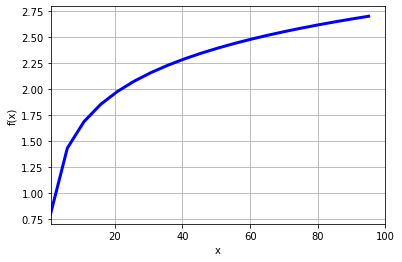

In [22]:
# нарисуем график зависимости безразмерного давления от безразмерного времени
# поскольку считает относительно медленно ограничим количество точек для расчета
mp.plot(soln5_inv_lapl,[1,100], points=20)

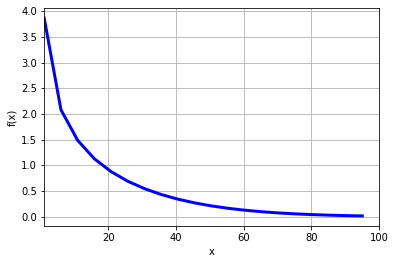

In [23]:
# нарисуем график зависимости безразмерного давления от безразмерного расстояния
# поскольку считает относительно медленно ограничим количество точек для расчета
td=1000
mp.plot(lambda rd: soln5_inv_lapl(td,rd),[1,100], points=20)

## 5 Построение численных решений на основе аналитического  с использованием `numpy` и `scipy` <a class="anchor" id="425"></a>

Использованием `mpmath` удобно для проверки расчетов, так как эта библиотека позволяет выбрать разные методы расчета и задать нужную точность. Но расчеты при этом проводятся медленно. Для более быстрых расчетов можно использовать расчетные функции `numpy` и `scipy`, а для обратного преобразования Лапласа библиотеку `anaflow`

In [24]:
# преобразование sympy выражения в lambda функцию с использованием numpy
soln5_numpy = sp.lambdify([u, r_d], soln5.rhs, modules = ['numpy', 'scipy'])

# после преобразования lambda функцию можно использовать для проведения расчетов как обычныую функцию

In [25]:
# пример расчета для одного значения, чтобы убедиться, что все работает
soln5_numpy(u=1, r_d=1)

0.6994839355937723

In [26]:
# определим функцию для расчета обратного преобразования Лапласа
# отдельная функция удобно чтобы передавать r_d второй параметр
def soln5_inv_lapl_numpy(t_d=1000, r_d=1):
    sol_lap = anaflow.get_lap_inv(soln5_numpy,  r_d=r_d)
    return sol_lap(t_d)

In [27]:
# пример расчета для одного значения, чтобы убедиться, что все работает
soln5_inv_lapl_numpy(1000)

array([3.86059079])

Построим графики с использованием сгенерированного решения. В отличии от `mpmath` решения считает быстрее, поэтому можно построить сразу много графиков.

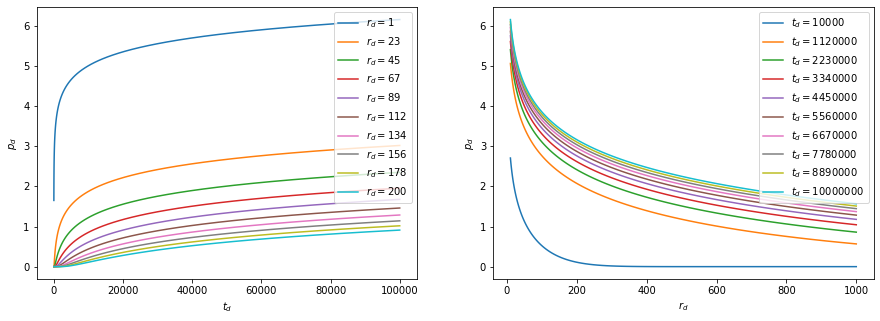

In [28]:
# зададим диапазоны изменения параметров для построения графиков
td_arr = np.logspace(1,5,100)
rd_arr = np.logspace(1,3,100)

# построим графики
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5])
for ri in np.linspace(1,200,10):
    ax1.plot(td_arr, soln5_inv_lapl_numpy(td_arr, r_d=ri), label = f'$r_d={ri:.0f}$')
for ti in np.linspace(1e4, 1e7,10):
    ax2.plot(rd_arr, np.squeeze( [soln5_inv_lapl_numpy(ti, r_d=ri) for ri in rd_arr ] ), label = f'$t_d={ti:.0f}$')
# наведем немного красоты
ax1.set_xlabel('$t_d$')
ax1.set_ylabel('$p_d$')
ax1.legend()
ax2.set_xlabel('$r_d$')
ax2.set_ylabel('$p_d$')
ax2.legend()
plt.show()